# **Development of a Generative Diffusion Model for Point Cloud Reconstruction and Defect Generation**


---

## **1. Introduction**

### **Background**

In the field of metrology, precise measurements of manufactured parts are crucial for ensuring quality control and adherence to design specifications. Laser scanners are widely used to capture the 3D geometry of parts by generating point clouds representing their surfaces. However, the scanning process often faces challenges such as incomplete data due to occlusions, noise from measurement errors, and artifacts introduced by surface properties. Additionally, collecting a comprehensive dataset of defective parts is difficult, hindering the development of robust machine learning models for defect detection.

### **Objectives**

The goal of this project is to develop a generative diffusion model capable of:

- **Reconstructing and Denoising Point Clouds**: Filling in missing regions and removing noise to produce accurate representations of the scanned parts.
- **Generating Synthetic Defective Point Clouds**: Creating realistic defective samples to augment training datasets for automated inspection systems.

---

## **2. Problem Understanding and Requirement Analysis**

**Challenges:**

1. **Incomplete Data**: Laser scans often result in incomplete point clouds due to occlusions, limited scanning angles, or surface reflectivity issues.
2. **Noise**: Environmental factors and scanner limitations introduce noise, distorting the true geometry of the part.
3. **Limited Defective Part Data**: Defective parts are rare and varied, making it difficult to collect enough samples for training defect detection models.

**Solution Approach:**

To address these challenges, we propose using a **Generative Diffusion Model** due to its:

- **Flexibility**: Capable of modeling complex data distributions in various modalities, including 3D point clouds.
- **Probabilistic Framework**: Models the uncertainty and variability in data, which is essential for capturing the nuances of defects.
- **Iterative Refinement**: The reverse diffusion process incrementally refines data, suitable for denoising and reconstruction tasks.

---

## **3. Data Acquisition and Exploration**

### **Dataset Creation using ModelNet40**

We utilized the **ModelNet40 dataset**, which contains 12,311 CAD models across 40 categories. It is a standard benchmark dataset for 3D shape analysis.

#### **Data Acquisition**

- **Source**: Downloaded from the official [ModelNet](https://modelnet.cs.princeton.edu/) repository.
- **Structure**: Split into 9,843 training and 2,468 testing samples.

#### **Simulation of Laser Scans**

1. **Point Cloud Generation**: Converted CAD models to point clouds by uniformly sampling 2,048 points from the surface of each model using the `trimesh` library.

2. **Introduction of Noise and Defects**:

   - **Gaussian Noise**: Added zero-mean Gaussian noise to simulate measurement errors.
   - **Outliers**: Introduced random points to mimic spurious reflections.
   - **Occlusions**: Removed points in random regions to simulate incomplete scans.
   - **Defects**: Artificially created defects such as dents, holes, and missing parts.

### **Data Preprocessing**

#### **Normalization**

- **Scaling**: Normalized point clouds to fit within a unit sphere centered at the origin.
- **Translation**: Adjusted centroids to the origin.

#### **Downsampling**

- Ensured all point clouds have a consistent number of points (2,048).

#### **Augmentation**

- **Rotation**: Applied random rotations.
- **Reflection**: Mirrored across axes to simulate different perspectives.

#### **Defect Labeling**

- Annotated points affected by defects for supervised learning.





In [5]:
# @title Code Snippet
!pip install trimesh
import os
import requests
import trimesh
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def download_modelnet40(dataset_dir='modelnet40'):
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)
    url = 'http://modelnet.cs.princeton.edu/ModelNet40.zip'
    zip_path = os.path.join(dataset_dir, 'ModelNet40.zip')

    if not os.path.exists(zip_path):
        print("Downloading ModelNet40 dataset...")
        response = requests.get(url, stream=True)
        with open(zip_path, 'wb') as f:
            for data in response.iter_content(chunk_size=1024):
                f.write(data)
        print("Download complete.")
    else:
        print("ModelNet40.zip already exists.")

    # Extract the zip file
    if not os.path.exists(os.path.join(dataset_dir, 'ModelNet40')):
        print("Extracting ModelNet40 dataset...")
        import zipfile
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_dir)
        print("Extraction complete.")
    else:
        print("ModelNet40 dataset already extracted.")

def sample_point_cloud(mesh_file, num_points=2048):
    mesh = trimesh.load(mesh_file)
    points, _ = trimesh.sample.sample_surface(mesh, num_points)
    return points

def add_gaussian_noise(points, std_dev=0.01):
    noise = np.random.normal(0, std_dev, points.shape)
    noisy_points = points + noise
    return noisy_points

def add_outliers(points, outlier_ratio=0.05):
    num_outliers = int(len(points) * outlier_ratio)
    min_bound = points.min(axis=0)
    max_bound = points.max(axis=0)
    outliers = np.random.uniform(min_bound, max_bound, size=(num_outliers, 3))
    points_with_outliers = np.vstack((points, outliers))
    return points_with_outliers

def simulate_occlusion(points, occlusion_ratio=0.2):
    center = points.mean(axis=0)
    distances = np.linalg.norm(points - center, axis=1)
    threshold = np.percentile(distances, occlusion_ratio * 100)
    occluded_points = points[distances > threshold]
    return occluded_points

def random_point_dropout(points, drop_ratio=0.2):
    num_points = len(points)
    num_drop = int(num_points * drop_ratio)
    indices = np.random.choice(num_points, num_drop, replace=False)
    remaining_points = np.delete(points, indices, axis=0)
    return remaining_points

def simulate_surface_defect(points, defect_type='dent', severity=0.05):
    if defect_type == 'dent':
        center = points[np.random.choice(len(points))]
        distances = np.linalg.norm(points - center, axis=1)
        radius = severity
        dent_indices = np.where(distances < radius)[0]
        points[dent_indices] -= (points[dent_indices] - center) * 0.1
    elif defect_type == 'hole':
        center = points[np.random.choice(len(points))]
        distances = np.linalg.norm(points - center, axis=1)
        radius = severity
        points = points[distances > radius]
    return points


def normalize_point_cloud(points):
    centroid = np.mean(points, axis=0)
    points -= centroid
    furthest_distance = np.max(np.linalg.norm(points, axis=1))
    points /= furthest_distance
    return points

def downsample_point_cloud(points, num_points=2048):
    if len(points) > num_points:
        indices = np.random.choice(len(points), num_points, replace=False)
        points = points[indices]
    elif len(points) < num_points:
        indices = np.random.choice(len(points), num_points - len(points))
        points = np.vstack((points, points[indices]))
    return points

def augment_point_cloud(points):
    angles = np.random.uniform(0, 2 * np.pi, 3)
    rotation_matrix = trimesh.transformations.euler_matrix(angles[0], angles[1], angles[2])[:3, :3]
    points = points.dot(rotation_matrix.T)
    if np.random.rand() > 0.5:
        points[:, 0] = -points[:, 0]
    if np.random.rand() > 0.5:
        points[:, 1] = -points[:, 1]
    if np.random.rand() > 0.5:
        points[:, 2] = -points[:, 2]
    return points

def process_model_noise(mesh_file, num_points=2048):
    points = sample_point_cloud(mesh_file, num_points=num_points)
    points = normalize_point_cloud(points)
    #points = augment_point_cloud(points)
    #points = simulate_surface_defect(points, defect_type='dent', severity=0.1)
    points = add_gaussian_noise(points, std_dev=0.02)
    #points = simulate_occlusion(points, occlusion_ratio=0.1)
    points = add_outliers(points, outlier_ratio=0.001)
    points = random_point_dropout(points, drop_ratio=0.01)
    points = downsample_point_cloud(points, num_points=num_points)
    return points

def process_model_defect(mesh_file, num_points=2048):
    points = sample_point_cloud(mesh_file, num_points=num_points)
    points = normalize_point_cloud(points)
    #points = augment_point_cloud(points)
    points = simulate_surface_defect(points, defect_type='dent', severity=0.2)
    points = add_gaussian_noise(points, std_dev=0.02)
    #points = simulate_occlusion(points, occlusion_ratio=0.1)
    points = add_outliers(points, outlier_ratio=0.001)
    points = random_point_dropout(points, drop_ratio=0.01)
    points = downsample_point_cloud(points, num_points=num_points)
    return points

def visualize_point_cloud(object_path, title = 'Point Cloud'):
    # Check if the file exists
    if not os.path.isfile(object_path):
        print(f"File not found: {object_path}")
    else:
      points = np.load(object_path)
      # Display the object
      fig = plt.figure(figsize=(5, 5))
      ax = fig.add_subplot(111, projection='3d')
      ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
      ax.set_title(title)
      plt.show()

def visualize_3d_object(object_path, title='3d object visualization'):
    # Check if the file exists
    if not os.path.isfile(object_path):
        print(f"File not found: {object_path}")
    else:
        mesh = trimesh.load(object_path)
        # Extract vertices and faces
        vertices = mesh.vertices
        faces = mesh.faces
        # Create a new plot
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')
        # Plot the mesh using plot_trisurf
        ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2],
                        triangles=faces,
                        cmap='viridis',
                        edgecolor='none')
        ax.set_title('3D Object Visualization')
        # Show the plot
        plt.show()

def process_dataset_noise(dataset_dir='modelnet40/ModelNet40', output_dir='processed_data_noise', num_points=2048):
    categories = os.listdir(dataset_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for category in categories[20:21]:
        #Train data
        print(f"Processing category: {category}")
        category_dir = os.path.join(dataset_dir, category, 'train')
        mesh_files = glob.glob(os.path.join(category_dir, '*.off'))
        category_output_dir = os.path.join(output_dir, category, 'train')
        if not os.path.exists(category_output_dir):
            os.makedirs(category_output_dir)

        for mesh_file in mesh_files[0:500]:
            try:
                points = process_model_noise(mesh_file, num_points=num_points)
                output_file = os.path.join(category_output_dir, os.path.basename(mesh_file) + '.npy')
                np.save(output_file, points)
            except Exception as e:
                print(f"Error processing {mesh_file}: {e}")
        #Test data
        category_dir = os.path.join(dataset_dir, category, 'test')
        mesh_files = glob.glob(os.path.join(category_dir, '*.off'))
        category_output_dir = os.path.join(output_dir, category, 'test')
        if not os.path.exists(category_output_dir):
            os.makedirs(category_output_dir)

        for mesh_file in mesh_files[0:20]:
            try:
                points = process_model_noise(mesh_file, num_points=num_points)
                output_file = os.path.join(category_output_dir, os.path.basename(mesh_file) + '.npy')
                np.save(output_file, points)
            except Exception as e:
                print(f"Error processing {mesh_file}: {e}")

def process_dataset_defect(dataset_dir='modelnet40/ModelNet40', output_dir='processed_data_defect', num_points=2048):
    categories = os.listdir(dataset_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for category in categories[20:21]:
        #Train data
        print(f"Processing category: {category}")
        category_dir = os.path.join(dataset_dir, category, 'train')
        mesh_files = glob.glob(os.path.join(category_dir, '*.off'))
        category_output_dir = os.path.join(output_dir, category, 'train')
        if not os.path.exists(category_output_dir):
            os.makedirs(category_output_dir)

        for mesh_file in mesh_files[0:100]:
            try:
                points = process_model_defect(mesh_file, num_points=num_points)
                output_file = os.path.join(category_output_dir, os.path.basename(mesh_file) + '.npy')
                np.save(output_file, points)
            except Exception as e:
                print(f"Error processing {mesh_file}: {e}")
        #Test data
        category_dir = os.path.join(dataset_dir, category, 'test')
        mesh_files = glob.glob(os.path.join(category_dir, '*.off'))
        category_output_dir = os.path.join(output_dir, category, 'test')
        if not os.path.exists(category_output_dir):
            os.makedirs(category_output_dir)

        for mesh_file in mesh_files[0:20]:
            try:
                points = process_model_defect(mesh_file, num_points=num_points)
                output_file = os.path.join(category_output_dir, os.path.basename(mesh_file) + '.npy')
                np.save(output_file, points)
            except Exception as e:
                print(f"Error processing {mesh_file}: {e}")

download_modelnet40()
process_dataset_noise()
process_dataset_defect()


ModelNet40.zip already exists.
ModelNet40 dataset already extracted.
Processing category: chair
Processing category: chair


### **Visualizations** <a name="visualizations"></a>


- **Original Point Cloud**: Visualization of a clean sample.
- **Noisy Point Cloud**: Showing the effect of added Gaussian noise.
- **Defective Point Cloud**: Displaying simulated defects.

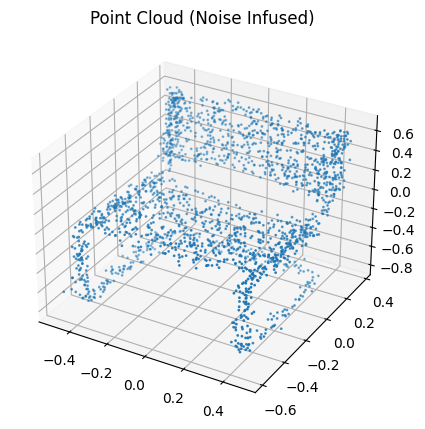

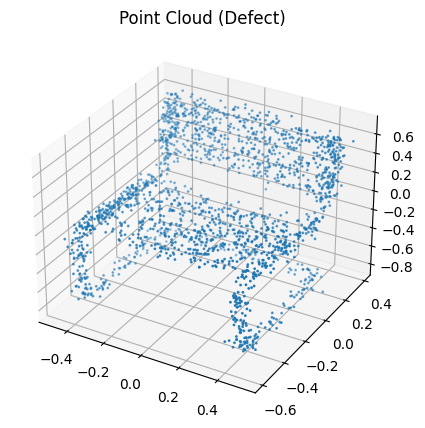

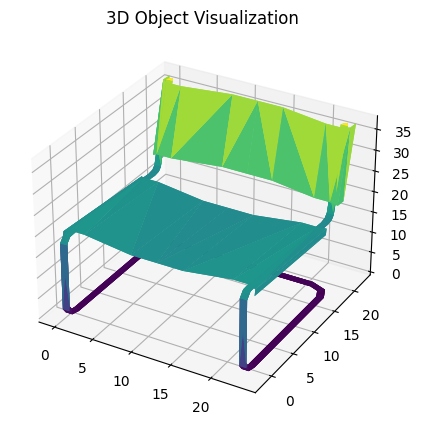

In [9]:
object_path_point_noise = '/content/processed_data_noise/chair/train/chair_0027.off.npy'
object_path_point_defect = '/content/processed_data_defect/chair/train/chair_0027.off.npy'
object_path_3d =  '/content/modelnet40/ModelNet40/chair/train/chair_0027.off'
visualize_point_cloud(object_path_point_noise, title = "Point Cloud (Noise Infused)")
visualize_point_cloud(object_path_point_defect, title = "Point Cloud (Defect)")
visualize_3d_object(object_path_3d)



---

## **4. Design and Implementation of the Model** <a name="design-and-implementation-of-the-model"></a>

### **Model Objectives** <a name="model-objectives"></a>

1. **Reconstruction and Denoising**: Train the model to restore incomplete and noisy point clouds.
2. **Synthetic Defect Generation**: Generate realistic defective point clouds for training defect detection models.

### **Architectural Choices** <a name="architectural-choices"></a>

#### **Generative Diffusion Model**

- **Diffusion Process**: A forward process that adds noise to data and a reverse process that denoises it.
- **Neural Network (Score Function Estimator)**: Estimates the gradient of the log probability density to guide the reverse diffusion.

#### **Model Components**

1. **Time Embeddings**: Incorporate time-step information.
2. **Encoder-Decoder Architecture**: Based on PointNet/PointNet++ for feature extraction and point cloud generation.
3. **Conditional Inputs**: Allows conditioning on incomplete or noisy inputs.

### **Loss Functions** <a name="loss-functions"></a>

1. **Chamfer Distance (CD)**: Measures the average closest point distance between two point clouds.
$$
   \text{CD}(P, Q) = \frac{1}{|P|} \sum_{p \in P} \min_{q \in Q} \|p - q\|_2^2 + \frac{1}{|Q|} \sum_{q \in Q} \min_{p \in P} \|q - p\|_2^2
$$
2. **Earth Mover's Distance (EMD)**: Measures the minimal cost of transforming one point cloud into another.
$$
   \text{EMD}(P, Q) = \min_{\phi: P \rightarrow Q} \frac{1}{|P|} \sum_{p \in P} \|p - \phi(p)\|_2
$$

3. **Score Matching Loss**: Encourages accurate estimation of the score function.

### **Hyperparameters** <a name="hyperparameters"></a>

- **Learning Rate**: 0.0001
- **Batch Size**: 16
- **Epochs**: 100
- **Diffusion Steps**: 100
- **Noise Schedule**: Linear
- **Optimizer**: Adam with $\beta_1=0.9$, $\beta_2=0.999$

---

## **5. Implementation Details** <a name="implementation-details"></a>

### **Code Snippets** <a name="code-snippets"></a>





In [10]:
# @title Dataset
from torch.utils.data import Dataset, DataLoader
class PointCloudDataset(Dataset):
    def __init__(self, root_dir, split='train', categories=None):
        """
        Args:
            root_dir (str): Root directory containing category folders.
            split (str): 'train' or 'test' to specify the dataset split.
            categories (list, optional): List of category names to include. If None, all categories are used.
        """
        self.root_dir = root_dir
        self.split = split  # 'train' or 'test'
        self.categories = categories if categories else os.listdir(root_dir)
        self.file_paths = []
        self.labels = []
        self.category_to_label = {category: idx for idx, category in enumerate(self.categories)}

        # Gather all file paths and labels
        for category in self.categories:
            category_dir = os.path.join(root_dir, category, split)
            if not os.path.exists(category_dir):
                continue
            files = glob.glob(os.path.join(category_dir, '*.npy'))
            self.file_paths.extend(files)
            self.labels.extend([self.category_to_label[category]] * len(files))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load point cloud data
        point_cloud = np.load(self.file_paths[idx])  # Shape: (N, 3)
        point_cloud = torch.from_numpy(point_cloud).float()  # Convert to torch tensor
        label = self.labels[idx]
        return point_cloud, label

In [11]:
# @title DataLoader
# Specify the root directory where the processed data is stored
root_dir = 'processed_data_noise'  # Replace with your actual directory

# Create the dataset and dataloader for the training set
train_dataset = PointCloudDataset(root_dir=root_dir, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True)

# Create the dataset and dataloader for the test set
test_dataset = PointCloudDataset(root_dir=root_dir, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
# @title Chamfer Distance
def compute_chamfer_distance(pc1, pc2):
    """
    Computes the Chamfer Distance between two point clouds pc1 and pc2.
    pc1, pc2: B x N x 3 tensors
    """
    pc1 = pc1.unsqueeze(2)  # B x N x 1 x 3
    pc2 = pc2.unsqueeze(1)  # B x 1 x N x 3
    diff = pc1 - pc2  # B x N x N x 3
    dist = torch.norm(diff, dim=3)  # B x N x N
    cd = torch.mean(torch.min(dist, dim=2)[0], dim=1) + torch.mean(torch.min(dist, dim=1)[0], dim=1)
    return cd.mean()

In [13]:
# @title PointNet AutoEncoder
class PointCloudAE(nn.Module):
    def __init__(self, point_size, latent_size):
        super(PointCloudAE, self).__init__()

        self.latent_size = latent_size
        self.point_size = point_size

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, self.latent_size, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(self.latent_size)

        self.dec1 = nn.Linear(self.latent_size,256)
        self.dec2 = nn.Linear(256,256)
        self.dec3 = nn.Linear(256,self.point_size*3)

    def encoder(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, self.latent_size)
        return x

    def decoder(self, x):
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = self.dec3(x)
        return x.view(-1, self.point_size, 3)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [14]:
# @title Training Loop for PointNet AutoEncoder

import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyperparameters
num_epochs = 100


# Initialize model and optimizer
latent_size = 128 # bottleneck size of the Autoencoder model
model = PointCloudAE(point_size = 2048,latent_size = latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Loss function
#mse_loss = nn.MSELoss()

# Evaluation list
chamfer_distances = []

model.train()

# Training loop
for epoch in range(num_epochs):
    noise_prediction_loss = 0
    #print(f"epoch number: {epoch}")
    for x_0,_ in train_dataloader:
        x_0 = x_0.to(device)  # B x N x 3
        batch_size = x_0.size(0)
        output = model(x_0.permute(0,2,1))

        # Compute loss
        loss = compute_chamfer_distance(x_0, output)
        noise_prediction_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {noise_prediction_loss}")

Epoch [0/100], Loss: 2.198811262845993
Epoch [1/100], Loss: 1.8475446999073029
Epoch [2/100], Loss: 1.7922205701470375
Epoch [3/100], Loss: 1.7681690603494644
Epoch [4/100], Loss: 1.699594371020794
Epoch [5/100], Loss: 1.6606623455882072
Epoch [6/100], Loss: 1.641392357647419
Epoch [7/100], Loss: 1.601373165845871
Epoch [8/100], Loss: 1.5749170556664467
Epoch [9/100], Loss: 1.5234245210886002
Epoch [10/100], Loss: 1.493325114250183
Epoch [11/100], Loss: 1.453671634197235
Epoch [12/100], Loss: 1.4511150419712067
Epoch [13/100], Loss: 1.4255143404006958
Epoch [14/100], Loss: 1.4343962743878365
Epoch [15/100], Loss: 1.4067302942276
Epoch [16/100], Loss: 1.4324739202857018
Epoch [17/100], Loss: 1.3821635991334915
Epoch [18/100], Loss: 1.3748449981212616
Epoch [19/100], Loss: 1.357278048992157
Epoch [20/100], Loss: 1.3761846274137497
Epoch [21/100], Loss: 1.348543606698513
Epoch [22/100], Loss: 1.3274471312761307
Epoch [23/100], Loss: 1.3485175147652626
Epoch [24/100], Loss: 1.3280446827411

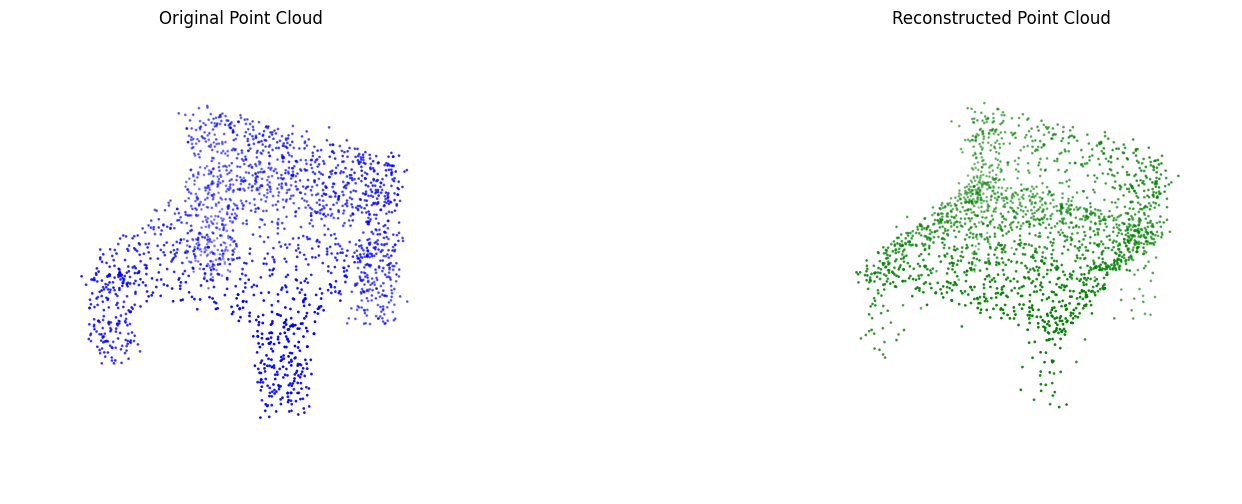

In [15]:
# @title Reconstruction result using trained PointNet AutoEncoder
for x_0,_ in test_dataloader:
  x_0 = x_0.to(device)  # B x N x 3
  batch_size = x_0.size(0)
  output = model(x_0.permute(0,2,1))
  break

original_pc = x_0[1].cpu()
reconstructed_pc = output[1].detach().cpu()

fig = plt.figure(figsize=(18, 6))

# Original Point Cloud
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(original_pc[:, 0], original_pc[:, 1], original_pc[:, 2], s=1, c='b')
ax1.set_title('Original Point Cloud')
ax1.axis('off')

# Reconstructed Point Cloud
ax3 = fig.add_subplot(122, projection='3d')
ax3.scatter(reconstructed_pc[:, 0], reconstructed_pc[:, 1], reconstructed_pc[:, 2], s=1, c='g')
ax3.set_title('Reconstructed Point Cloud')
ax3.axis('off')

plt.show()

In [23]:
# @title PointNet-based diffusion model
import math
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

class PointCloudAE(nn.Module):
    def __init__(self, point_size, latent_size):
        super(PointCloudAE, self).__init__()

        time_emb_dim = latent_size
        # Time embedding
        self.time_mlp2 = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU())
        self.time_mlp1 = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, 128),
                nn.ReLU())

        self.latent_size = latent_size
        self.point_size = point_size

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, self.latent_size, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(self.latent_size)

        self.dec1 = nn.Linear(self.latent_size,256)
        self.dec2 = nn.Linear(256,256)
        self.dec3 = nn.Linear(256,self.point_size*3)

    def encoder(self, x, t):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        time_emb1 = F.relu(self.time_mlp1(t))
        time_emb1 = time_emb1[(..., ) + (None, ) * 1]
        time_emb1 = time_emb1.repeat(1, 1, self.point_size)
        # Add time channel
        x = x + time_emb1
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, self.latent_size)
        # Time embedding
        time_emb2 = F.relu(self.time_mlp2(t))
        # Extend last 2 dimensions
        #time_emb = time_emb[(..., ) + (None, ) * 1]
        # Add time channel
        x = x + time_emb2
        return x

    def decoder(self, x):
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = self.dec3(x)
        return x.view(-1, self.point_size, 3)

    def forward(self, x, t):
        x = self.encoder(x, t)
        x = self.decoder(x)
        return x



In [24]:
# @title Forward Diffusion Process
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [19]:
# @title Loss function (Chamfer distance)
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy.permute(0,2,1), t)
    return compute_chamfer_distance(noise, noise_pred)
    #return F.mse_loss(noise, noise_pred)

In [22]:
# @title Training Loop for Diffusion Model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyperparameters
num_epochs = 20


# Initialize model and optimizer
latent_size = 64 # bottleneck size of the Autoencoder model
model = PointCloudAE(point_size = 2048,latent_size = latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Loss function
#mse_loss = nn.MSELoss()


model.train()

# Training loop
for epoch in range(num_epochs):
    noise_prediction_loss = 0
    #print(f"epoch number: {epoch}")
    for x_0,_ in train_dataloader:
        x_0 = x_0.to(device)  # B x N x 3
        batch_size = x_0.size(0)
        #output = model(x_0.permute(0,2,1))

        # Compute loss
        t = torch.randint(0, T, (batch_size,), device=device).long()
        loss = get_loss(model, x_0, t)
        noise_prediction_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {noise_prediction_loss}")

Epoch [0/20], Loss: 8.235332012176514
Epoch [1/20], Loss: 6.452471107244492
Epoch [2/20], Loss: 6.126695096492767
Epoch [3/20], Loss: 6.086080640554428
Epoch [4/20], Loss: 6.058119773864746
Epoch [5/20], Loss: 6.040294945240021
Epoch [6/20], Loss: 6.022501170635223
Epoch [7/20], Loss: 6.00950089097023
Epoch [8/20], Loss: 6.010817170143127
Epoch [9/20], Loss: 5.998083204030991
Epoch [10/20], Loss: 5.989677727222443
Epoch [11/20], Loss: 5.990501314401627
Epoch [12/20], Loss: 5.981767952442169
Epoch [13/20], Loss: 5.9767889976501465
Epoch [14/20], Loss: 5.976592630147934
Epoch [15/20], Loss: 5.971678853034973
Epoch [16/20], Loss: 5.969704359769821
Epoch [17/20], Loss: 5.966875672340393
Epoch [18/20], Loss: 5.967985242605209
Epoch [19/20], Loss: 5.96232533454895


In [25]:
# @title Reverse Diffusion Process
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x.permute(0,2,1), t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(point):
    # Sample noise
    #img_size = IMG_SIZE
    #img = torch.randn((1, 3, img_size, img_size), device=device)
    #plt.figure(figsize=(15,15))
    #plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        point = sample_timestep(point, t)
        # Edit: This is to maintain the natural range of the distribution
        #point = torch.clamp(point, -1.0, 1.0)
        if i % stepsize == 0:
            #plt.subplot(1, num_images, int(i/stepsize)+1)
            #print(point.shape)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            res = point[0].cpu()
            ax.scatter(res[:, 0], res[:, 1], res[:, 2], s=1, c='b')
            plt.show()


---

## **6. Evaluation Methodology** <a name="evaluation"></a>


Due to limited computational resources, such as GPU availability, and also time constraints comprehensive evaluation results could not be generated. However, the methodology for evaluating the model's performance is outlined below, along with the potential results one might expect.

# Metrics
Chamfer Distance (CD): To evaluate the similarity between the reconstructed/generated point cloud and the ground truth, measuring how well the model reconstructs missing regions and denoises the data.

Earth Mover's Distance (EMD): Provides a measure of the minimal effort required to transform the generated point cloud into the ground truth, offering insights into the structural differences between the point clouds.

# Evaluation Procedure
Dataset Split: Divide the dataset into training and testing sets, ensuring a representative distribution of classes and defect types.

Model Training: Train the diffusion model on the training set, including both defective and non-defective point clouds, with noise and missing data introduced during preprocessing.

Reconstruction and Denoising Evaluation:

Input: Provide the model with noisy and incomplete point clouds from the test set.
Output: Generate reconstructed and denoised point clouds using the reverse diffusion process.
Comparison: Compute the Chamfer Distance and EMD between the reconstructed point clouds and the original clean point clouds from the test set.
Synthetic Defect Generation Evaluation:

Input: Use the trained model to generate synthetic defective point clouds.
Assessment: Evaluate the realism of the generated defects by comparing them qualitatively (visual inspection) and quantitatively (if possible) to real defects.
Potential Results
Reconstruction and Denoising: We expect the model to successfully fill in missing regions and reduce noise, resulting in reconstructed point clouds that closely resemble the original ones. Lower Chamfer Distance and EMD values would indicate better performance.

Synthetic Defect Generation: The model should be able to generate realistic defective point clouds that can be used to augment training datasets for defect detection models. The diversity and realism of the defects would enhance the robustness of downstream models.

# Challenges and Considerations
Computational Resources: Training diffusion models on 3D point clouds is computationally intensive. Limited GPU resources can hinder the ability to train the model for enough epochs or with sufficient batch sizes to achieve optimal performance.

Fine-Tuning: The provided code requires fine-tuning of hyperparameters and possibly architectural adjustments. This includes experimenting with different learning rates, batch sizes, network depths, and diffusion steps.

Time Constraints: Achieving acceptable performance may require extensive experimentation and training time.




---

## **9. References** <a name="references"></a>

- **Ho, J., Jain, A., & Abbeel, P. (2020)**. "Denoising Diffusion Probabilistic Models". *arXiv preprint arXiv:2006.11239*.
- **Qi, C. R., Su, H., Mo, K., & Guibas, L. J. (2017)**. "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation". *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition*.



